In [1]:
import random

import pandas as pd
import json
from tqdm import tqdm

#change it for your local path!
path_to_jsonl = r'C:\Users\kamus\PycharmProjects\metamath2py\metamath2py.jsonl'
df = []
with open(path_to_jsonl, 'r') as f:
    for line in tqdm(f):
        df.append(json.loads(line))
df = pd.DataFrame(df)

44891it [01:05, 682.09it/s] 


In [2]:
df['lines_in_lemmon'] = df['lemmon_notation'].str.split('\n').apply(lambda x: len(x))

In [3]:
df = df[(df['lines_in_lemmon'] > 5) & (df['lines_in_lemmon'] < 25)]
len(df)

6133

In [4]:
from openai import OpenAI


client = OpenAI(api_key='')

model = "gpt-4.1-mini"

In [5]:
from pydantic import BaseModel, Field

class GeneratedStep(BaseModel):
    step: str = Field(description="Your step")

next_step_prompt = """
=== Below is a partial proof ===
{proof}
=== Generate next step using the same notation===
Next step:"""

In [6]:
class StepCompletionScore(BaseModel):
    score: str = Field(description="Your score")

judge_prompt = """
You are an expert in formal logic and automated theorem proving. You will evaluate a proposed proof step by comparing it against the expected correct version.

You will be shown:
- A proof context
- A proposed continuation of the proof
- The expected correct continuation

You are a mathematical assistant evaluating automatically generated code steps that try to reproduce a reference proof step.
Your task is to give a score from 0 to 5 based on how close the generated step is to the reference, using the following rubric:

5 — Almost identical:
The structure, arguments, number of arguments, and general logic are essentially the same. Minor renamings or ordering differences are acceptable.

4 — Very similar:
The overall structure is correct. Arguments may differ slightly, or one may be missing. The logic is clearly aiming for the same goal.

3 — Similar structure but significant mismatches: The function name or key arguments are wrong. Structure is intact but not matching the reference closely.

2 — Roughly related but flawed:
Structure is inconsistent. Some code elements are there, but key aspects are missing, shuffled, or misused. The step does not clearly resemble the reference.

1 — Poor structure or unreadable:
Step is syntactically messy, mostly unrelated to the reference. May contain code, but it's not understandable as a valid proof step.

0 — Nonsensical or broken:
No valid code structure. Step is garbage or unrelated.


"""

judge_request = """

=== Proof Context ===
{proof_context}
=== Proposed Continuation ===
{proposed_continuation}
=== Expected Continuation ===
{expected_continuation}
"""

In [7]:
import random
def build_X_y(proof):
    parts = proof.strip().split('\n')
    parts = [p.strip() for p in parts]
    border = random.randint(len(parts) // 2, len(parts) - 1)
    return "\n".join(parts[:border]), parts[border]

def estimate_prediction(proof):
    X, y = build_X_y(proof)
    prompt = next_step_prompt.format(proof=X)

    generated_step = client.responses.parse(
        model=model,
        input=prompt,
        text_format = GeneratedStep
    )
    generate_step_usage = generated_step.usage
    generated_step = generated_step.output_parsed.step


    judge_input = judge_request.format(proof_context=X, proposed_continuation=generated_step, expected_continuation=y)
    estimation = client.responses.parse(
        model = model,
        instructions=judge_prompt,
        input=judge_input,
        text_format = StepCompletionScore
    )

    estimation_usage = estimation.usage
    estimation = estimation.output_parsed.score

    return X, y, generated_step, estimation, generate_step_usage, estimation_usage


In [13]:
usage = []

input_tokens, output_tokens = 0, 0

for i, row in tqdm(df.iterrows(), total=len(df)):
    lemmon_notation_X, lemmon_notation_y, lemmon_notation_response, lemmon_notation_estimation_result, usage1, usage2 = estimate_prediction(row['lemmon_notation'])

    proof_lines_X, proof_lines_y, proof_lines_response, proof_lines_estimation_result, usage3, usage4 = estimate_prediction(row['proof_lines'])
    usage.extend([usage1, usage2, usage3, usage4])

    result = {
        'name': row['name'],
        'lemmon_notation_input':lemmon_notation_X,
        'lemmon_notation_expected_step':lemmon_notation_y,
        'lemmon_notation_predicted_step':lemmon_notation_response,
        'lemmon_notation_estimation_result':lemmon_notation_estimation_result,
        'proof_lines_input':proof_lines_X,
        'proof_lines_expected_step':proof_lines_y,
        'proof_lines_predicted_step':proof_lines_response,
        'proof_lines_estimation_result':proof_lines_estimation_result
    }

    with open(r'step_completion_v1.jsonl', 'a+') as f:
        f.write(json.dumps(result) + '\n')

#note: you may find this file: step_completion_v1.jsonl on hugginface


100%|██████████| 6133/6133 [6:12:58<00:00,  3.65s/it]    


In [23]:
step_completion_results = []
with open(r'step_completion_v1.jsonl', 'r') as f:
    for line in f:
        step_completion_results.append(json.loads(line))

In [24]:
step_completion_results = pd.DataFrame(step_completion_results)

In [26]:
a0k0 = step_completion_results[step_completion_results['name']=='A0K0']


59    1 wps           $f wff ps\n2 wph           $f ...
Name: lemmon_notation_input, dtype: object
59    x_1 = "wff ps"\nx_2 = "wff ph"\nx_3 = "wff ch"...
Name: proof_lines_input, dtype: object


In [30]:
print(a0k0['lemmon_notation_input'].values[0])

1 wps           $f wff ps
2 wph           $f wff ph
3 wch           $f wff ch
4 wth           $f wff th
5 wta           $f wff ta
6 wph           $f wff ph


In [ ]:

print(a0k0['proof_lines_input'])

In [37]:
diffs = step_completion_results['proof_lines_estimation_result'].astype(int) - step_completion_results['lemmon_notation_estimation_result'].astype(int)


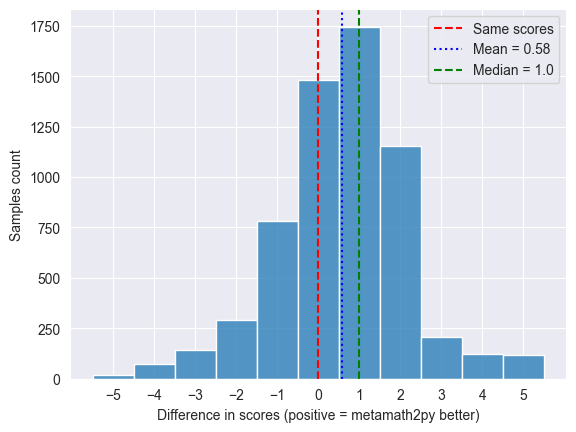

In [44]:
min_diff = diffs.min()
max_diff = diffs.max()
bins = range(-5, 6)
sns.histplot(
    diffs,
    bins=bins,  # корректные бины
    discrete=True,
    kde=False
)
plt.xticks(ticks=list(bins))
plt.xlabel("Difference in scores (positive = metamath2py better)")
plt.ylabel("Samples count")
plt.grid(True)
plt.axvline(0, color='red', linestyle='--', label="Same scores")
mean = np.mean(diffs)
median = np.median(diffs)
plt.axvline(mean, color='blue', linestyle=':', label=f"Mean = {mean:.2f}")
plt.axvline(median, color='green', linestyle='--', label=f"Median = {median}")

plt.legend()
plt.show()


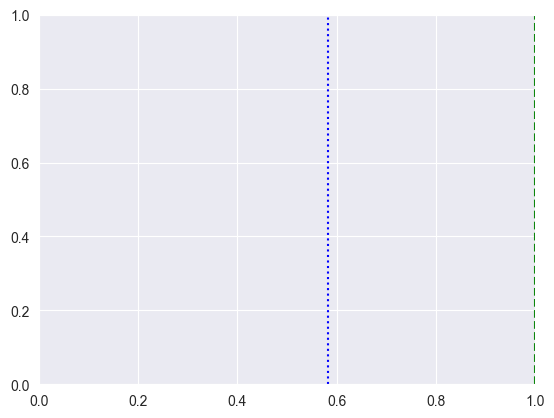

In [39]:
import numpy as np


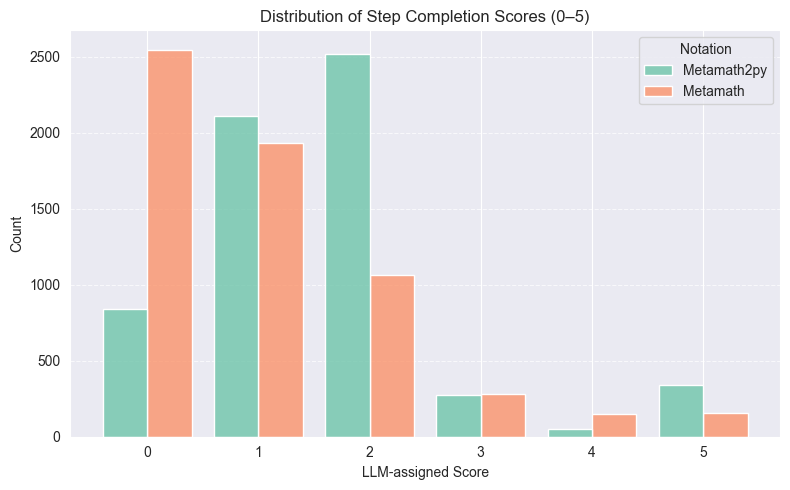

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

scores.columns = ['Metamath2py', 'Metamath']

scores_long = scores.melt(var_name="Notation", value_name="Score")

# Рисуем
plt.figure(figsize=(8, 5))
sns.histplot(
    data=scores_long,
    x="Score",
    hue="Notation",
    discrete=True,
    shrink=0.8,
    multiple="dodge",
    palette="Set2"
)
plt.title("Distribution of Step Completion Scores (0–5)")
plt.xlabel("LLM-assigned Score")
plt.ylabel("Count")
plt.xticks([0, 1, 2, 3, 4, 5])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


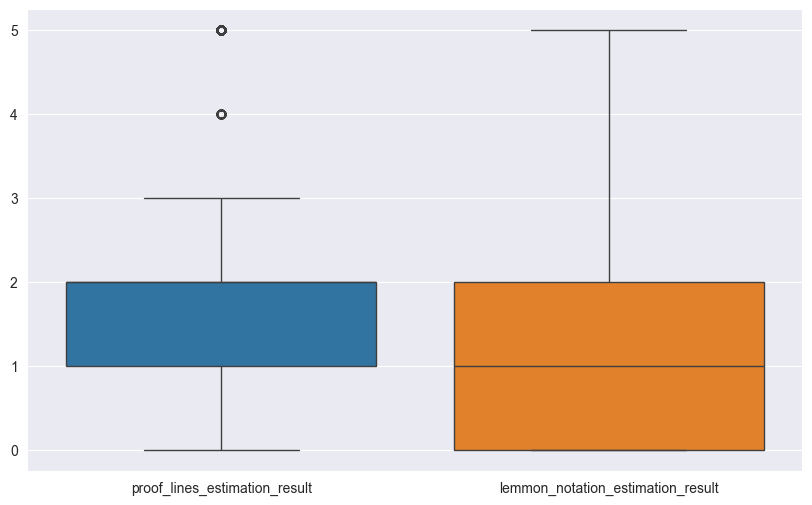

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(data=scores)
plt.show()

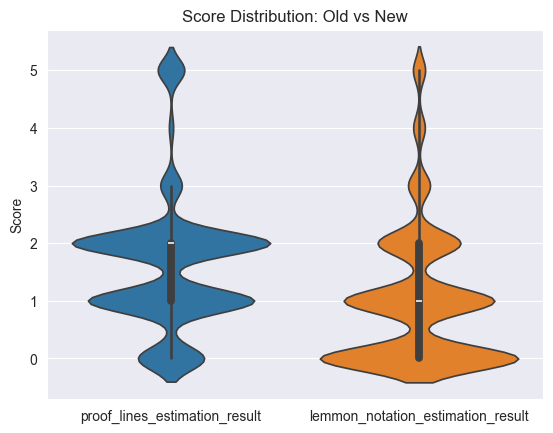

In [18]:
sns.violinplot(data=scores)
plt.title("Score Distribution: Old vs New")
plt.ylabel("Score")
plt.show()